In [1]:
fit_results = { "tags": [], "keys": [], "a/b": [] }         # e.g tag = IPDP, key = mupi, a/b = num/num

In [236]:
tag = "IPPV"
#tag = "IPDP"
#tag = "IPPV"

In [281]:
catdict = {
    r"$\mu-\pi$"     : 20014002,
    r"$\mu-\rho$"    : 20014004,
    r"$\mu-a^{1}_{3\pi}$" : 20014008,
}
shiftdict = {
    "cp_even": {"shift": 150, "colour": "red", "location": "upper right"},
    "cp_odd": {"shift": 151, "colour": "blue", "location": "lower left"},
    "cp_maxmix": {"shift": 0, "colour": "black", "location": "lower right"},
}
simpledict = {
    r"$\mu-\pi$"     : "mupi",
    r"$\mu-\rho$"    : "murho",
    r"$\mu-a^{1}_{3\pi}$" : "mua13pr",
}

In [282]:
import os
import re
#import ROOT
import hist
import pickle
import mplhep as hep
from glob import glob
import numpy as np
import awkward as ak
from tabulate import tabulate
from IPython import embed
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
# iminuit
import iminuit
from iminuit import Minuit
from iminuit.cost import LeastSquares
hep.style.use("CMS")
print("iminuit version:", iminuit.__version__)

iminuit version: 2.30.1


In [283]:
def comp_asymmetry(arr1, arr2):
    # https://github.com/Ksavva1021/TIDAL/blob/656f992ae056b3fed0061f2b3efb49905c39834d/CP_Tools/scripts/assymetry.py#L26
    return (1/arr1.size)*np.sum(np.abs((arr1-arr2)/(arr1+arr2)))

def comp_asymmetry_error(arr1, arr2, err1, err2):
    # Terms for partial derivatives
    denom = arr1 + arr2
    term1 = err1 * np.abs((2 * arr2) / (denom**2))
    term2 = err2 * np.abs((2 * arr1) / (denom**2))
    # Propagate errors
    sigma_A = np.sqrt(np.sum(term1**2 + term2**2)) / arr1.size
    return sigma_A

In [284]:
def makesimple(latex_str):
    # Remove LaTeX commands (e.g., $...$, \frac, \text, etc.)
    plain_text = re.sub(r'\\[a-zA-Z]+\{[^}]*\}', '', latex_str)  # Remove \command{...}
    print(plain_text)
    plain_text = re.sub(r'\$.*?\$', '', plain_text)  # Remove math expressions between $...$
    print(plain_text)
    plain_text = re.sub(r'\\[a-zA-Z]+', '', plain_text)  # Remove other LaTeX commands (e.g., \chi)
    print(plain_text)

    # Clean up any remaining special characters
    plain_text = plain_text.replace('$', '')  # Remove leftover dollar signs
    print(plain_text)    
    return plain_text

In [285]:
np.linspace(0., 10., 20)

array([ 0.        ,  0.52631579,  1.05263158,  1.57894737,  2.10526316,
        2.63157895,  3.15789474,  3.68421053,  4.21052632,  4.73684211,
        5.26315789,  5.78947368,  6.31578947,  6.84210526,  7.36842105,
        7.89473684,  8.42105263,  8.94736842,  9.47368421, 10.        ])

In [286]:
file = f"INPUT/shifted_hist__PhiCPGen_{tag}.pickle"

In [287]:
fileptr = open(file, 'rb')
data = pickle.load(fileptr)
fileptr.close()

In [288]:
data

Hist(
  IntCategory([1e+07, 200000, 1e+06, 3e+06, 15000, 300000, 10000, 11000, 16000, 2.0014e+07, 6000, 2.0014e+07, 1, 4.0013e+07, 2.0014e+07, 2.0014e+07, 100000, 9000, 4.0013e+07, 12000, 4.0013e+07, 4.0013e+07, 7000, 4000, 2.0014e+07, 4.0013e+07, 8000, 3000, 2000, 4e+06, 1000, 2e+06, 5000], growth=True, name='category'),
  IntCategory([11100], growth=True, name='process'),
  IntCategory([0, 150, 151], growth=True, name='shift'),
  Variable([0, 0.314159, 0.628319, 0.942478, 1.25664, 1.5708, 1.88496, 2.19911, 2.51327, 2.82743, 3.14159, 3.45575, 3.76991, 4.08407, 4.39823, 4.71239, 5.02655, 5.34071, 5.65487, 5.96903, 6.28319], name='PhiCPGen_IPPV', label='$\\Phi_{CP}^{IP-PV}$ (rad) [Gen level]'),
  storage=Weight()) # Sum: WeightedSum(value=16389.6, variance=77.3296)

In [292]:
axes = data.axes
category_axis  = axes['category']
category_axis

IntCategory([1e+07, 200000, 1e+06, 3e+06, 15000, 300000, 10000, 11000, 16000, 2.0014e+07, 6000, 2.0014e+07, 1, 4.0013e+07, 2.0014e+07, 2.0014e+07, 100000, 9000, 4.0013e+07, 12000, 4.0013e+07, 4.0013e+07, 7000, 4000, 2.0014e+07, 4.0013e+07, 8000, 3000, 2000, 4e+06, 1000, 2e+06, 5000], growth=True, name='category')

In [293]:
shift_axis = axes['shift']
shift_axis

IntCategory([0, 150, 151], growth=True, name='shift')

In [294]:
cparray = {}
for ckey, cval in catdict.items():
    shiftarray = {}
    for key,props in shiftdict.items():
        shift = props["shift"]
        colour = props["colour"]
        location = props["location"]

        if cval not in category_axis:
            print(f"WARNING : {cval} not in categories")
            continue

        shift_index = shift_axis.index(props["shift"])    
        values = data[category_axis.index(cval), :, shift_axis.index(props["shift"]), :].values()
        # https://github.com/oponcet/CPinHToTauTau/blob/FF_dev_project/script_FF/fake_factor_derivation/src/input_processing.py#L133
        errors = data[category_axis.index(cval), :, shift_axis.index(props["shift"]), :].variances() ** 0.5
        #shiftarray[key] = data[category_axis.index(cval), :, shift_axis.index(props["shift"]), :].values()
        shiftarray[key] = {
            "values": values,
            "errors": errors,
            "colour": colour,
            "location": location,
        }

        print(f"category : {ckey}, CatValue : {cval}, \n Key: {key}, \t Type of value: {type(val)}, Value : {val} \n\n")
    cparray[ckey] = shiftarray
#cparray

category : $\mu-\pi$, CatValue : 20014002, 
 Key: cp_even, 	 Type of value: <class 'dict'>, Value : {'cp_even': {'values': array([[3.94121094, 4.12193288, 4.29324415, 4.49335961, 4.5094257 ,
        4.66969949, 4.90182226, 5.32345621, 5.42033858, 5.64337006,
        5.55117641, 5.44510376, 5.44372512, 5.19012993, 4.95071583,
        4.75073041, 4.56006924, 4.4343873 , 4.24314195, 3.8201639 ]]), 'errors': array([[0.12797222, 0.13284629, 0.13504091, 0.13999401, 0.14141638,
        0.1453817 , 0.15003236, 0.15911496, 0.16233604, 0.16731282,
        0.16474875, 0.16119882, 0.16259195, 0.15484802, 0.14948508,
        0.14555218, 0.14739549, 0.13606516, 0.15182106, 0.12449677]]), 'color': 'red', 'location': 'upper right'}, 'cp_odd': {'values': array([[5.57946705, 5.60185374, 5.45741471, 5.01391948, 4.71655332,
        4.54121454, 4.22920835, 4.16190901, 4.01374552, 3.88855716,
        4.01526895, 4.10208456, 4.25284131, 4.54982348, 4.67670157,
        4.88436199, 5.35311371, 5.72457291, 5.72

In [295]:
#cparray.keys()
hypothesis_zip.keys()

dict_keys(['values', 'errors', 'color', 'location'])

$\mu-\pi$
category cp_even props {'shift': 150, 'colour': 'red', 'location': 'upper right'}


shift 150 colour red location upper right
category cp_odd props {'shift': 151, 'colour': 'blue', 'location': 'lower left'}


shift 151 colour blue location lower left
category cp_maxmix props {'shift': 0, 'colour': 'black', 'location': 'lower right'}


shift 0 colour black location lower right


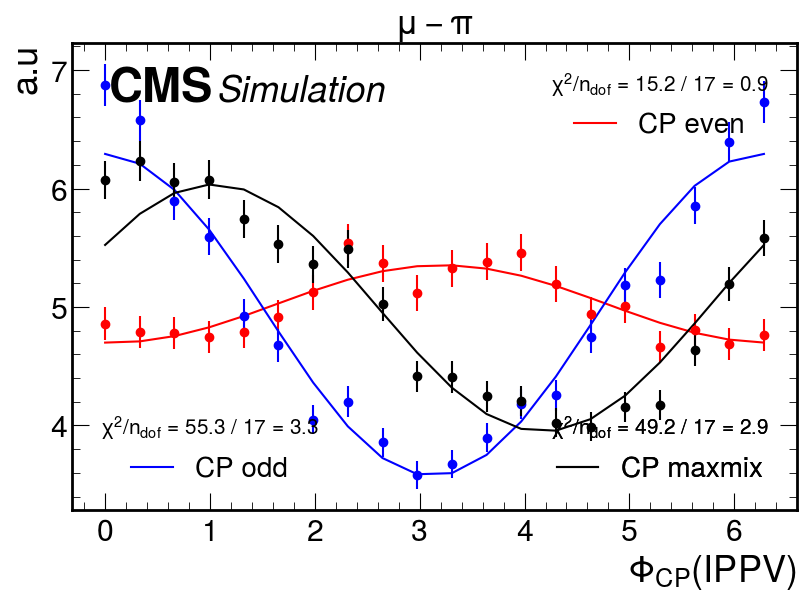

$\mu-\rho$
category cp_even props {'shift': 150, 'colour': 'red', 'location': 'upper right'}


shift 150 colour red location upper right
category cp_odd props {'shift': 151, 'colour': 'blue', 'location': 'lower left'}


shift 151 colour blue location lower left
category cp_maxmix props {'shift': 0, 'colour': 'black', 'location': 'lower right'}


shift 0 colour black location lower right


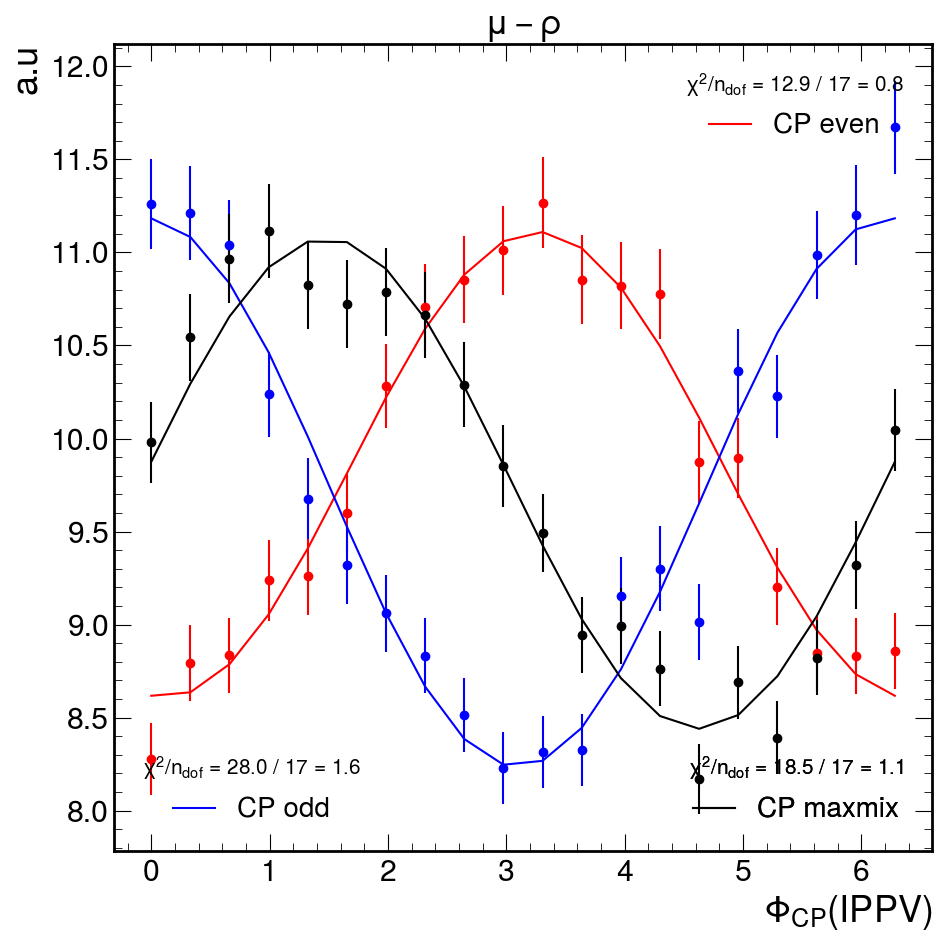

$\mu-a^{1}_{3\pi}$
category cp_even props {'shift': 150, 'colour': 'red', 'location': 'upper right'}


shift 150 colour red location upper right
category cp_odd props {'shift': 151, 'colour': 'blue', 'location': 'lower left'}


shift 151 colour blue location lower left
category cp_maxmix props {'shift': 0, 'colour': 'black', 'location': 'lower right'}


shift 0 colour black location lower right


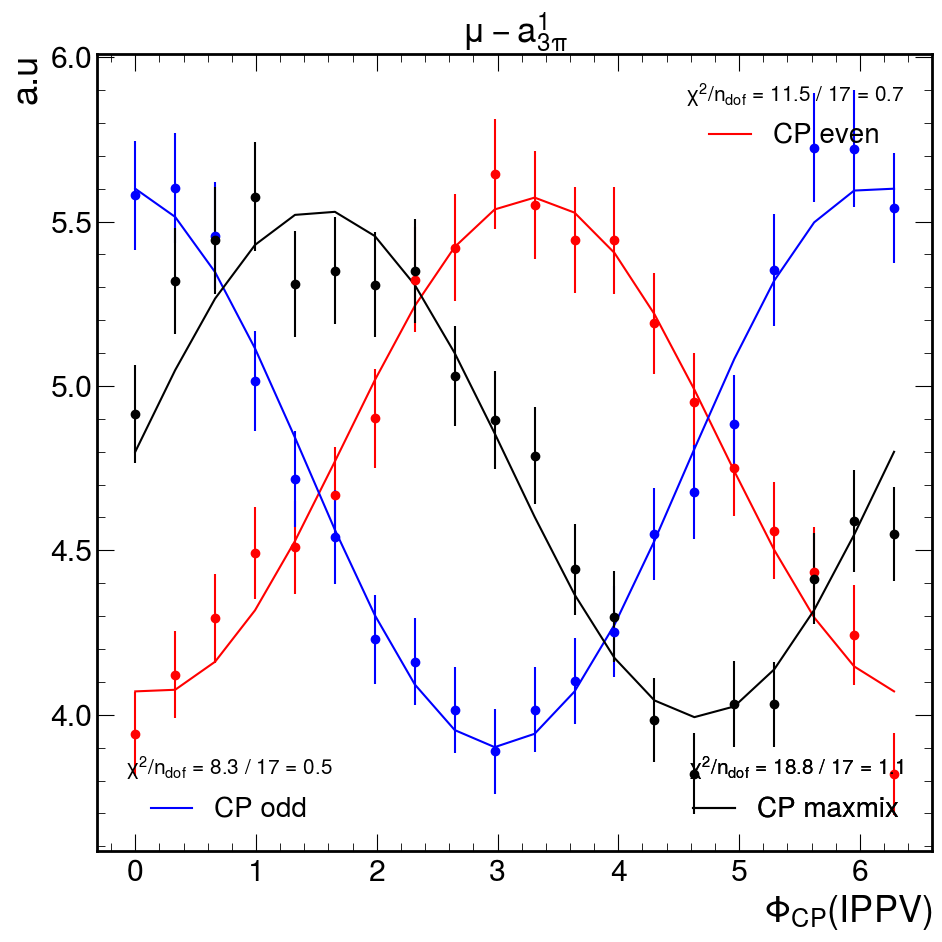

In [300]:
cpfitarray = {}
x = np.linspace(0., 2*np.pi, 20)
def model(x, a, b, c):
    return a*np.cos(x+c) + b

def fit(x, y, err=0.05, model=model):
    lsq = LeastSquares(x, y, err, model)
    m = Minuit(lsq, a=0.1, b=0.1, c=1.0)
    #m.scan(ncall=100)
    m.fixed = False
    m.migrad()  # finds minimum of least_squares function
    m.hesse()  # accurately computes uncertainties
    return m, err, m.values["a"], m.errors["a"], m.values["b"], m.errors["b"], m.values["c"]

plt.figure(figsize=(8.9, 6.6))
hep.cms.text("Simulation", loc=1)

for key, val in cparray.items():
    print(key)
    if len(val) == 0:
        print(f"WARNING : {key} has an empty dict")
        continue

    results = {}
    for category, props in shiftdict.items():
        shift, colour, location = props["shift"], props["colour"], props["location"]
        print("category", category, "props", props)
        print("\n")
        print("shift", shift, "colour", colour, "location", location)
        
        hypothesis_zip = val[category]
        hypothesis, hypothesis_err = np.ravel(hypothesis_zip["values"]), np.ravel(hypothesis_zip["errors"])

        # Fit the Hypothesis
        m, err, a, sigma_a, b, sigma_b, c = fit(x, hypothesis, hypothesis_err)
        
        results[category] = {
            "m": m,
            "err": err,
        }
        
        # Plot the results
        plt.errorbar(x, hypothesis, hypothesis_err, fmt="o", color=colour)
        fit_curve = model(x, *m.values)
        plt.plot(x, fit_curve, color=colour)
        fit_info = [
            f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.1f}",
        ]
        legend_handle = Line2D([0], [0], color=colour, label=f"CP {category[3:]}")
        legend = plt.legend(handles=[legend_handle], title="\n".join(fit_info), frameon=False, loc=location, fontsize=20, title_fontsize=15)
        plt.gca().add_artist(legend)


    # Save the results for each fit
    fit_results["tags"].append(tag)
    fit_results["keys"].append(key)

    cpfitarray[key] = {f"m_{category[3:]}": results[category]["m"] for category in shiftdict} # = {"m_even": m_even, "m_odd": m_odd, "m_maxmix": m_maxmix}

    plt.xlabel(r"$\Phi_{CP}$"+f"({tag})")
    plt.ylabel("a.u")
    plt.title(f"{key}", fontsize=25, loc='center')
    plt.tight_layout()
    plt.savefig(f"OUTPUT/{tag}_{simpledict[key]}.pdf", dpi=300)
    plt.show()


In [297]:
#for category, shifts in shiftdict.items():
#    print("category ",category,"\n shifts ", shifts, "\n\n")

#val[category]["values"]
#category
#hypothesis_zip["errors"]
#val[category]
np.shape(np.ravel(hypothesis))
np.ravel(hypothesis)
hypothesis

array([4.91514665, 5.31925491, 5.44389415, 5.57505597, 5.31035263,
       5.35033907, 5.30806761, 5.34949258, 5.03062098, 4.89615834,
       4.78807514, 4.44239079, 4.29761679, 3.98327077, 3.82048324,
       4.03214601, 4.03195198, 4.41421109, 4.58962354, 4.55073459])

In [ ]:
## plot
    plt.figure(figsize=(8.9, 6.6))
    #plt.subplots_adjust(top=0.85)

    # Add CMS-style text
    hep.cms.text("Simulation", loc=1)
    #plt.text(0, 21, "CMS Simulation", fontsize=12, ha='left')

    
    ### plot CP even
    plt.errorbar(x, even, even_err, fmt="o",color="red")
    #plt.scatter(x, even, color="red")
    even_fit = model(x, *m_even.values)
    lin1, = plt.plot(x, even_fit, color="red")

    # display legend with some fit info
    fit_info_even = [
        f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m_even.fval:.1f} / {m_even.ndof:.0f} = {m_even.fmin.reduced_chi2:.1f}",
    ]

    #for p, v, e in zip(m.parameters, m.values, m.errors):
    #    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")
    leg_even_handle = Line2D([0], [0], color='red', label="CP even")
    leg_even = plt.legend(handles=[leg_even_handle],title="\n".join(fit_info_even), frameon=False, loc="upper right", fontsize=20, title_fontsize=15)
    plt.gca().add_artist(leg_even)


    ### plot CP odd
    plt.errorbar(x, odd, odd_err, fmt="o",color="blue")
    #plt.scatter(x, odd, color="blue")
    odd_fit = model(x, *m_odd.values)
    lin2, = plt.plot(x, odd_fit, color="blue")

    fit_info_odd = [
        f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m_odd.fval:.1f} / {m_odd.ndof:.0f} = {m_odd.fmin.reduced_chi2:.1f}",
    ]

    leg_odd_handle = Line2D([0], [0], color='blue', label="CP odd")
    leg_odd = plt.legend(handles=[leg_odd_handle], title="\n".join(fit_info_odd), frameon=False, loc="lower left", fontsize=20, title_fontsize=15)
    plt.gca().add_artist(leg_odd)
    

    ### plot maxmix
    plt.errorbar(x, maxmix, maxmix_err, fmt="o",color="black")
    #plt.scatter(x, maxmix, color="black")
    maxmix_fit = model(x, *m_maxmix.values)
    lin3, = plt.plot(x, maxmix_fit, color="black")

    fit_info_maxmix = [
        f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m_maxmix.fval:.1f} / {m_maxmix.ndof:.0f} = {m_maxmix.fmin.reduced_chi2:.1f}",
    ]

    leg_maxmix_handle = Line2D([0], [0], color='black', label="CP maximal mixing")
    leg_maxmix = plt.legend(handles=[leg_maxmix_handle], title="\n".join(fit_info_maxmix), frameon=False, loc="lower right", fontsize=20, title_fontsize=15)
    plt.gca().add_artist(leg_maxmix)

    plt.xlabel(r"$\Phi_{CP}$"+f"({tag})")
    plt.ylabel("a.u")

    asymm_even_odd = comp_asymmetry(even_fit, odd_fit)
    asymm_even_maxmix = comp_asymmetry(even_fit, maxmix_fit)
    asymm_odd_maxmix = comp_asymmetry(odd_fit, maxmix_fit)

    asymm_error_even_odd = comp_asymmetry_error(even_fit, odd_fit, even_err, odd_err)
    asymm_error_even_maxmix = comp_asymmetry_error(even_fit, maxmix_fit, even_err, maxmix_err)
    asymm_error_odd_maxmix = comp_asymmetry_error(odd_fit, maxmix_fit, odd_err, maxmix_err)

    
    plt.title(f"{key} ($A_{{even,odd}}$ = {round(asymm_even_odd, 3)}$\pm${round(asymm_error_even_odd, 3)})", fontsize=25, loc='center')


    fits_y_min = np.min([np.min(even_fit),np.min(odd_fit),np.min(maxmix_fit)])
    fits_y_max = np.max([np.max(even_fit),np.max(odd_fit),np.max(maxmix_fit)])
    y_min = fits_y_min - 0.3 * fits_y_min
    y_max = fits_y_max + 0.2 * fits_y_max
    
    plt.ylim(y_min,y_max)

    plt.tight_layout()
    plt.savefig(f"OUTPUT/{tag}_{simpledict[key]}.pdf", dpi=300)
    plt.show()

In [60]:
fit_results

{'tags': ['IPPV', 'IPPV', 'IPPV', 'IPDP', 'IPDP', 'IPIP'],
 'keys': ['$\\mu-\\pi$',
  '$\\mu-\\rho$',
  '$\\mu-a^{1}_{3\\pi}$',
  '$\\mu-\\rho$',
  '$\\mu-a^{1}_{3\\pi}$',
  '$\\mu-\\pi$'],
 'a/b': [{'a/b_even': (0.06511358194675525, np.float64(0.00898024599292469)),
   'a/b_odd': (0.27548047484614585, np.float64(0.009164177254262267)),
   'a/b_maxmix': (-0.20897607875044916, np.float64(-0.009279678832013366))},
  {'a/b_even': (-0.12688958185463506, np.float64(-0.006945341514723791)),
   'a/b_odd': (0.1518118542407656, np.float64(0.007069607056826996)),
   'a/b_maxmix': (-0.13501273180244047, np.float64(-0.007262188529184766))},
  {'a/b_even': (-0.1566830068480969, np.float64(-0.009600383550306091)),
   'a/b_odd': (0.17954305765358494, np.float64(0.00973830104217747)),
   'a/b_maxmix': (-0.16201151004965003, np.float64(-0.009958533887106729))},
  {'a/b_even': (0.15110972958347613, np.float64(0.006974098697849087)),
   'a/b_odd': (-0.14266450668015893, np.float64(-0.0070481389486890715)

keys : $\mu-\pi$, tags: ['IPIP', 'IPPV'], even: [(0.06511358194675525, np.float64(0.00898024599292469)), (0.21245827881529308, np.float64(0.009094764624867855))], odd: [(0.27548047484614585, np.float64(0.009164177254262267)), (-0.03721641506636339, np.float64(-0.009018639790013471))], maxmix: [(-0.20897607875044916, np.float64(-0.009279678832013366)), (-0.14603141287617777, np.float64(-0.00924061886435739))]


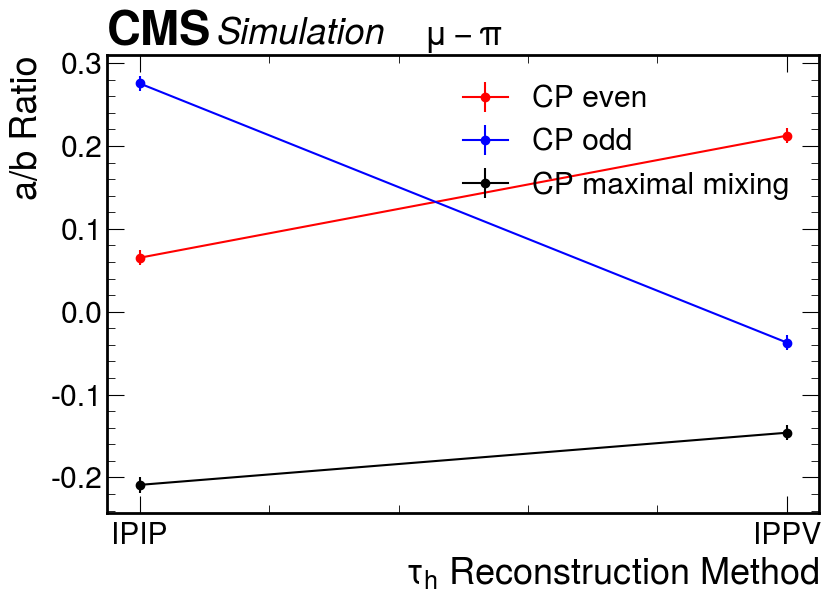

keys : $\mu-a^{1}_{3\pi}$, tags: ['IPDP', 'IPPV'], even: [(-0.1566830068480969, np.float64(-0.009600383550306091)), (0.07201307938255457, np.float64(0.00953561012368653))], odd: [(0.17954305765358494, np.float64(0.00973830104217747)), (-0.08779887435739275, np.float64(-0.009599703103976478))], maxmix: [(-0.16201151004965003, np.float64(-0.009958533887106729)), (-0.08856296659953386, np.float64(-0.010092929009935447))]


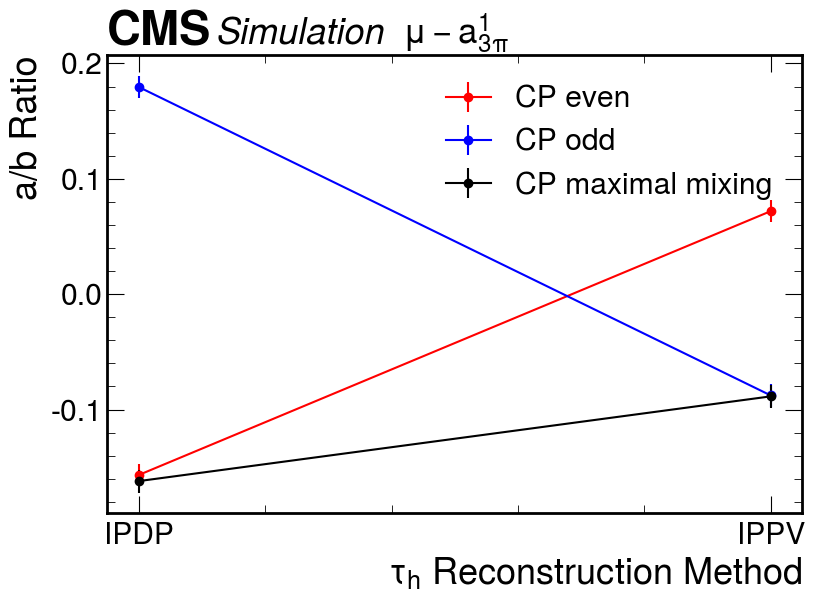

keys : $\mu-\rho$, tags: ['IPDP', 'IPPV'], even: [(-0.12688958185463506, np.float64(-0.006945341514723791)), (0.15110972958347613, np.float64(0.006974098697849087))], odd: [(0.1518118542407656, np.float64(0.007069607056826996)), (-0.14266450668015893, np.float64(-0.0070481389486890715))], maxmix: [(-0.13501273180244047, np.float64(-0.007262188529184766)), (0.14061143001469806, np.float64(0.007286608176890762))]


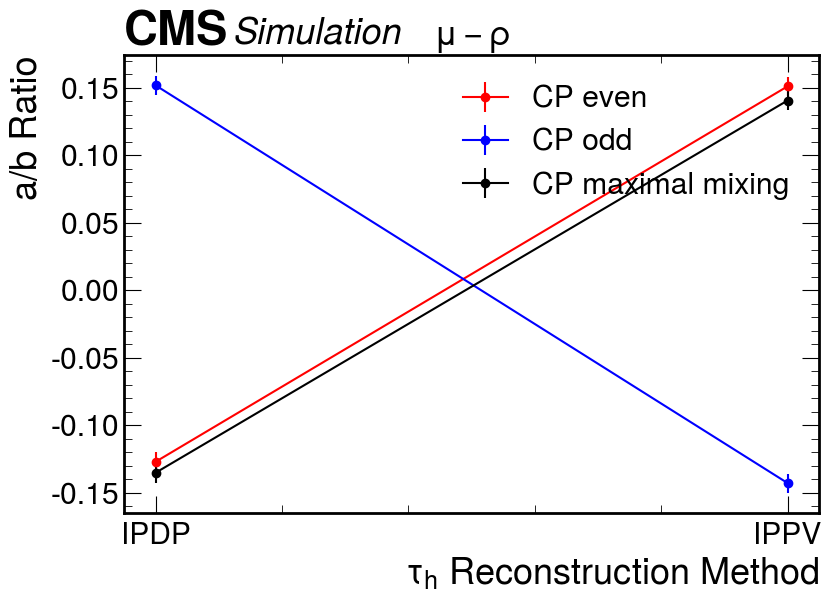

In [61]:
set_keys = set(fit_results["keys"])  # Unique keys in the results

for key in set_keys: #loops over mupi, murho, mua1

    # Extract tags and a/b ratios for this key
    
    tags = [fit_results["tags"][i] for i, k in enumerate(fit_results["keys"]) if k == key]
    a_b_ratios = [fit_results["a/b"][i] for i, k in enumerate(fit_results["keys"]) if k == key]

    # If no data for this key, skip
    if not tags or not a_b_ratios:
        print(f"No data found for key {key}, skipping...")
        continue

    # Extract ratios for existing entries
    even_ratios = [a_b.get("a/b_even", (None, None)) for a_b in a_b_ratios]
    odd_ratios = [a_b.get("a/b_odd", (None, None)) for a_b in a_b_ratios]
    maxmix_ratios = [a_b.get("a/b_maxmix", (None, None)) for a_b in a_b_ratios]

    even_vals, even_errs = zip(*even_ratios)
    odd_vals, odd_errs = zip(*odd_ratios)
    maxmix_vals, maxmix_errs = zip(*maxmix_ratios)

    even_erro = np.abs(np.array(even_errs).tolist())
    odd_erro = np.abs(np.array(odd_errs).tolist())
    maxmix_erro = np.abs(np.array(maxmix_errs).tolist())

    plt.figure(figsize=(8.9, 6.6))
    hep.cms.text("Simulation", loc=0) 

    sorted_tags = sorted(tags)

    # Plot data
    plt.errorbar(sorted_tags, even_vals, yerr=even_erro, fmt='-o', label="CP even", color="red")
    plt.errorbar(sorted_tags, odd_vals, yerr=odd_erro, fmt='-o', label="CP odd", color="blue")
    plt.errorbar(sorted_tags, maxmix_vals, yerr=maxmix_erro, fmt='-o', label="CP maximal mixing", color="black")

    print(f"keys : {key}, tags: {sorted_tags}, even: {even_ratios}, odd: {odd_ratios}, maxmix: {maxmix_ratios}")

    # Configure plot labels and save
    plt.xlabel(r"$\tau_h$ Reconstruction Method")
    plt.ylabel("a/b Ratio")
    plt.title(f"{key}", fontsize=25)
    plt.legend(frameon=False, loc="upper right")
    plt.tight_layout()
    plt.savefig(f"OUTPUT/comparison_ab_ratios_by_fit_types_{simpledict[key]}.pdf", dpi=300)
    plt.show()


In [62]:
cpfitarray

{'$\\mu-\\pi$': {'m_even': ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 39.66 (χ²/ndof = 2.3)      │              Nfcn = 97               │
│ EDM = 1.34e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────

In [63]:
m_maxmix

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 44.63 (χ²/ndof = 2.6)      │              Nfcn = 96               │
│ EDM = 3.47e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   -0.73   │   0.05    │            │            │         │         │       │
│ 1 │ b    │   5.000   │   0.032   │            │            │         │         │       │
│ 2 │ c    │  -14.75   │   0.06    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────┐
│   │       a       b       c │
├───┼─────────────────────────┤
│ a │ 0.00211 -0.0001 -0.0001 │
│ b │ -0.0001 0.00104  0.0002 │
│ c │ -0.0001  0.0002 0.00382 │
└───┴─────────────────────────┘

In [64]:
m_odd

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 31.38 (χ²/ndof = 1.8)      │              Nfcn = 120              │
│ EDM = 2.18e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   -0.19   │   0.05    │            │            │         │         │       │
│ 1 │ b    │   5.020   │   0.033   │            │            │         │         │       │
│ 2 │ c    │   0.09    │   0.25    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────┐
│   │       a       b       c │
├───┼─────────────────────────┤
│ a │ 0.00205 -0.0002  -0.000 │
│ b │ -0.0002 0.00106 -0.0001 │
│ c │  -0.000 -0.0001   0.062 │
└───┴─────────────────────────┘

In [65]:
m_even

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 39.66 (χ²/ndof = 2.3)      │              Nfcn = 97               │
│ EDM = 1.34e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.05    │   0.04    │            │            │         │         │       │
│ 1 │ b    │   4.951   │   0.032   │            │            │         │         │       │
│ 2 │ c    │   -0.04   │   0.04    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────┐
│   │       a       b       c │
├───┼─────────────────────────┤
│ a │ 0.00198  0.0002  0.0000 │
│ b │  0.0002 0.00102 -0.0000 │
│ c │  0.0000 -0.0000 0.00187 │
└───┴─────────────────────────┘

In [66]:
m_even.values

<ValueView a=1.051853116995057 b=4.950869049963059 c=-0.03577663499552555>

In [67]:
m_maxmix.values

<ValueView a=-0.730190150465484 b=5.000226568270096 c=-14.745833267690738>

In [68]:
m_odd.values

<ValueView a=-0.18684315957206696 b=5.020450229794913 c=0.0876170823026966>

In [69]:
x

array([0.        , 0.33069396, 0.66138793, 0.99208189, 1.32277585,
       1.65346982, 1.98416378, 2.31485774, 2.64555171, 2.97624567,
       3.30693964, 3.6376336 , 3.96832756, 4.29902153, 4.62971549,
       4.96040945, 5.29110342, 5.62179738, 5.95249134, 6.28318531])